In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# note this is regression analysis with pipes implemented.

# Regression analysis consists of a set of machine learning methods that allow us to predict a continuous outcome variable (y) based on the value of one or multiple predictor variables (x). ... Linear regression is the most simple and popular technique for predicting a continuous variable.¶


http://www.sthda.com/english/wiki/regression-analysis-essentials-for-machine-learning

In [ ]:
#!pip install lazypredict

In [ ]:
#Adding all possible machine learning techniques, not going to use all.
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import StandardScaler
from keras.layers.advanced_activations import ReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten,Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
import keras
import cv2
import tensorflow
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import plotly.express as px
import plotly.graph_objs as go
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

**First Glance, there is no need for onehot encoding as everything is in floats/ints **

In [ ]:
data = pd.read_csv('../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')
data.head()

# Step 1:
First check the values

# Step 2:Check for missing Values ( we can easily do this by using pandas profiling from: https://github.com/pandas-profiling/pandas-profiling)

This will give us important uses: Such as what variables are significant. Checking for null values and finding more info about the variables themselves and their correlations.

In [ ]:
#import pandas_profiling
#from pandas_profiling import ProfileReport

#profile = ProfileReport(data, title='Pandas Profiling Report')
#profile

# Or simply we just check if there are no missing values

In [ ]:
#We can see that there is no null values inside 
data.isnull().values.any()

In [ ]:
#Not entirely alot of data, but still an amount to create multiple graphs for data exploration.
data.shape

In [ ]:
data.info()
#Data is floats and ints which are fine for predictions.

# ##**Step 3: Visualization and Correlation****

In [ ]:
#import pandas and seaborn to plot again to make sure, typically its useful to plot the 
import pandas as pd
import seaborn as sb

In [ ]:
#Create heatmap using seaborn style gradient.
heat = sns.light_palette('green', as_cmap = True)
style = data.style.background_gradient(cmap = heat)
style

In [ ]:
#####
plt.subplots(figsize=(11, 11)) 
sns.heatmap(data.corr(),annot=True)

**Serum_creatinine, Age and Death(0 and 1)

Age and Death_event are typically Weakly and positively correlated but not significantly.
Serum and Death are Typically higher, but still a weak positive correlation.

Are Death_event and age show any significance?
Do Serum and death show any significance?**

**IF visualized, we can see that these three are somewhat correlated.**

In [ ]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(2,2,1, projection="3d")
ax.scatter(data['DEATH_EVENT'],data['age'],data['serum_creatinine'],c="darkgreen",alpha=.5)
ax.set(xlabel='DEATH_EVENT',ylabel='age',zlabel='serum_creatinine')
ax.set(ylim=[0,100])
#ax.set(xlim=[0,10])

# Step 4: SPLITTING THE DATA

In [ ]:
#####
train_set, test_set = train_test_split(data, train_size=0.8, test_size=0.2, random_state = 42)
print(len(train_set), ' Training Set +', len(test_set), ' Testing Set')

# Step 5: PREPROCESS

Max-Min Normalization will be used as we will obtain smaller standard deviations.

In [ ]:
#####
#scaling after splitting data to avoid leaks
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#train
scaler.fit(train_set)
train_set = scaler.transform(train_set)
#Convert to table format - MinMaxScaler
train_set = pd.DataFrame(data=data, columns=["age", "serum_creatinine","anaemia","creatinine_phosphokinase","diabetes","ejection_fraction","high_blood_pressure","platelets"
                                                        ,"serum_sodium","sex","smoking","DEATH_EVENT"])
#test
scaler.fit(test_set)
test_set = scaler.transform(test_set)
#Convert to table format - MinMaxScaler
test_set = pd.DataFrame(data=data, columns=["age", "serum_creatinine","anaemia","creatinine_phosphokinase","diabetes","ejection_fraction","high_blood_pressure","platelets"
                                                        ,"serum_sodium","sex","smoking","DEATH_EVENT"])

# Step 6: BUILDING THE MODEL

In [ ]:

#Perform hyper parameter optimization
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [ ]:
#######
#Same for train set(Target is purchase)
X_train = train_set.drop("DEATH_EVENT", axis=1) # drop labels for training set
y_train = train_set["DEATH_EVENT"].copy()

#same for test set
X_test = test_set.drop("DEATH_EVENT", axis=1)
y_test = test_set["DEATH_EVENT"].copy()

# Step 7: Predicting and Accuracy Score

(note: score method uses internal scoring(crossvlidation and gridsearch))
(So refer to the accuracy_score for the actual score)

In [ ]:
#------KNeighborsClassifier-----
pipelineone = Pipeline([('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors':[1,2,3,4,5,6,7,8,9,10],
              'knn__leaf_size': [10,20,30,40,50,60,70,80,90,100]
             }

#Gridsearch takes in param_grid, and pipeline.
gridone = GridSearchCV(pipelineone, param_grid, cv =5, scoring = 'roc_auc')
gridone.fit(X_train, y_train)

testscore = gridone.score(X_test, y_test)
trainscore = gridone.score(X_train, y_train)
print('----AUC Values from KNN train and test Set----')
print('Internal test score accuracy:', testscore)
print('Internal train score accuracy:', trainscore)


#on the testing data
y_testpred = gridone.predict(X_test)

#on the training data
y_trainpred = gridone.predict(X_train)

# summarize and present ROC score
#roc takes in y_true and y_score
KNNtest = accuracy_score(y_test, y_testpred)
KNNtrain = accuracy_score(y_train, y_trainpred)
print('Best parameters: ', gridone.best_params_)
print('KNN Accuracy score from test set: ', (KNNtest))
print('KNN Accuracy score  from train set: ', (KNNtrain))



In [ ]:
#-------LogisticRegression-----
#[0.001, 0.01, 0.1, 1, 10, 100, 1000]
pipelinetwo = Pipeline([('logisticregression', LogisticRegression())])
param_grid = {'logisticregression__penalty' : ['l2'],
              'logisticregression__C' : [10],
              'logisticregression__solver' : ['liblinear']}
#Gridsearch takes in param_grid, and pipeline.
gridtwo = GridSearchCV(pipelinetwo, param_grid, cv =5, scoring = 'roc_auc')
gridtwo.fit(X_train, y_train)

testscore = gridtwo.score(X_test, y_test)
trainscore = gridtwo.score(X_train, y_train)
print('----AUC Values from Logistic Regression train and test Set----')
print('Internal test score accuracy: ', testscore)
print('Internal train score accuracy: ', trainscore)


#on the testing data
y_testpred = gridtwo.predict(X_test)

#on the training data
y_trainpred = gridtwo.predict(X_train)

# summarize and present ROC score
#roc takes in y_true and y_score
logtest = accuracy_score(y_test, y_testpred)
logtrain = accuracy_score(y_train, y_trainpred)
print('Best parameters: ', gridtwo.best_params_)
print('Logistic Regress Accuracy Score from test set: ', (logtest))
print('Logistic Regress Accuracy Score from train set: ', (logtrain))

In [ ]:
#-----------svm.SVC------------
pipelinethree = Pipeline([('svc', SVC(kernel='rbf', probability = True))])

param_grid = {
        'svc__C': [1],
        'svc__gamma': ['scale']}

#Gridsearch takes in param_grid, and pipeline.
gridthree = GridSearchCV(pipelinethree, param_grid, cv =5, scoring = 'roc_auc')
gridthree.fit(X_train, y_train)

testscore = gridthree.score(X_test, y_test)
trainscore = gridthree.score(X_train, y_train)
print('----AUC Values from SVM train and test Set----')
print('Internal test score accuracy:', testscore)
print('Internal train score accuracy:', trainscore)

#on the testing data
y_testpred = gridthree.predict(X_test)

#on the training data
y_trainpred = gridthree.predict(X_train)

# summarize and present ROC score
#roc takes in y_true and y_score
SVMtest = accuracy_score(y_test, y_testpred)
SVMtrain = accuracy_score(y_train, y_trainpred)
print('Best parameters: ', gridthree.best_params_)
print('SVC accuracy score from test set: ', (SVMtest))
print('SVC accuracy score from train set: ', (SVMtrain))

# Step 8: Conclusion using different classifier models:

(from our test set to qualify performance)

KNN Accuracy score: 0.6 = 60%

Logistic Regression Accuracy score: 0.7833333333333333 = 78.3%

SVC Accuracy score: 0.7 = 70%


Overall it seems Logistic regression comes out as king which comes out as no surprise.

# Step 9:
# Quickly check other classifiers
To get a sense if Logistic Regression really is a great model.

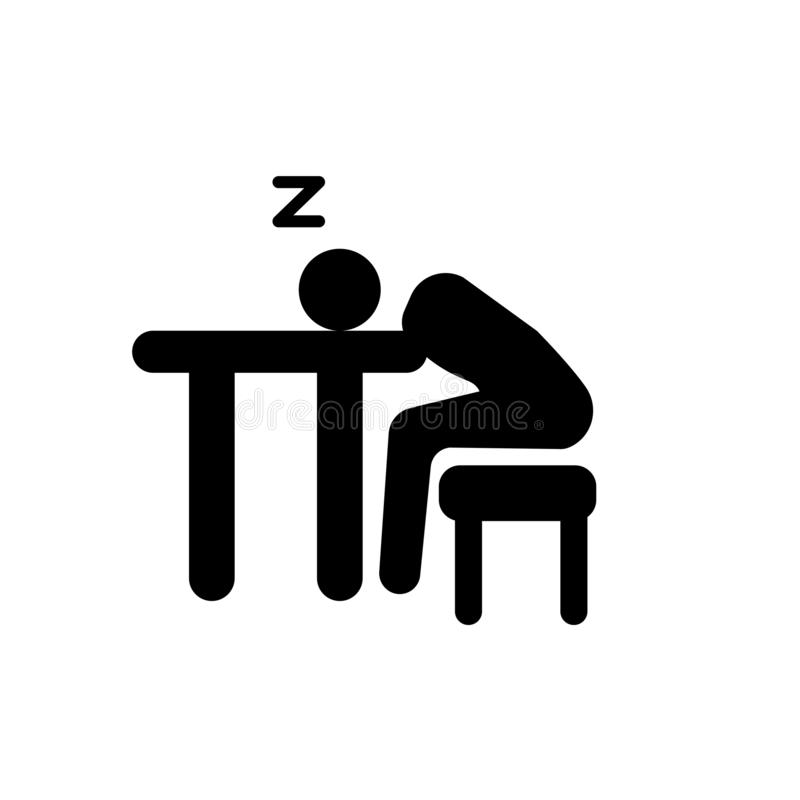

Logistic Regression, SVC and KNN with hyper parameter optimization can most likely stand out for accuracy

# Conclusion:

LabelPropagation, XGBClassifier, RandomForestClassifier, DecisionTreeClassifier, ExtraTreeClassifier, ExtraTreesClassifier, LabelSpreading
are all also valid.